In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import joblib

from geojson import Point, Feature
from turfpy import measurement
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

from scipy.interpolate import griddata

import time


2025-06-13 10:32:35.928599: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 10:32:36.439111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749803556.456556  718165 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749803556.462181  718165 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749803556.639149  718165 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
ini = time.time()

In [3]:
period = 1

In [4]:
event = "Earthquake to be inferred"
magnitude_event = 7.0
latitude_event = 63.86241607923315
longitude_event = -20.41723877793937
depth_event = 11.4 

In [ ]:
model = tf.keras.models.load_model("Model_Iceland_3layers_8Feat_pSA_1_Batch100_Epoch15.h5")
scaler_X = joblib.load("scaler_X_1s.save") 
scaler_y = joblib.load("scaler_y_1s.save") 

2025-06-13 10:32:46.386288: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
latMax = 64.5
latMin = 63.5
lonMax = -20
lonMin = -23

rang_lat = float(latMax-latMin)/40
rang_lon = float(lonMax-lonMin)/40
dfStations = pd.DataFrame()

sitesLat = np.arange(latMin, latMax, rang_lat)
sitesLon = np.arange(lonMin, lonMax, rang_lon)

vecStations = np.array(np.meshgrid(sitesLat,sitesLon)).T.reshape(-1,2)
dfStations['Site_Lat'] = vecStations[:,0]
dfStations['Site_Lon'] = vecStations[:,1]

In [7]:
azim1 = np.zeros(len(vecStations))
euclDist = np.zeros(len(vecStations))
for rj in np.arange(len(vecStations)):
    start1 = Feature(geometry=Point((longitude_event, latitude_event))) #Lat-Lon Earthquake
    end1 = Feature(geometry=Point((dfStations['Site_Lon'].iloc[rj], dfStations['Site_Lat'].iloc[rj]))) #Lat-Lon Station
    d1 = measurement.distance(start1,end1,'km')
    azim1[rj] = measurement.bearing(start1,end1) #print(d1/1000)
    euclDist[rj] =  np.sqrt((d1)**2 + (depth_event)**2)
    
df_InputData_CS_sites = pd.DataFrame()
df_InputData_CS_sites["Site_Lat"] = dfStations["Site_Lat"].values
df_InputData_CS_sites["Site_Lon"] = dfStations["Site_Lon"].values
df_InputData_CS_sites["Magnitude"] = magnitude_event*np.ones(len(vecStations))
df_InputData_CS_sites["Hypocenter_Lat"] = latitude_event*np.ones(len(vecStations))
df_InputData_CS_sites["Hypocenter_Lon"] = longitude_event*np.ones(len(vecStations))
df_InputData_CS_sites["Hypocenter_Depth"] = depth_event*np.ones(len(vecStations))
df_InputData_CS_sites["Haversine_distance"] = euclDist
df_InputData_CS_sites["Azimuth"] = azim1
df_InputData_CS_sites["Intensity Value "+str(period)+"s"] = 0
df_InputData_CS_sites["y_pred"] = 0
print(df_InputData_CS_sites)
feature_cols = ["Site_Lat", "Site_Lon","Magnitude","Hypocenter_Lat","Hypocenter_Lon","Hypocenter_Depth","Haversine_distance","Azimuth"]

      Site_Lat  Site_Lon  Magnitude  Hypocenter_Lat  Hypocenter_Lon  \
0       63.500   -23.000        7.0       63.862416      -20.417239   
1       63.500   -22.925        7.0       63.862416      -20.417239   
2       63.500   -22.850        7.0       63.862416      -20.417239   
3       63.500   -22.775        7.0       63.862416      -20.417239   
4       63.500   -22.700        7.0       63.862416      -20.417239   
...        ...       ...        ...             ...             ...   
1595    64.475   -20.375        7.0       63.862416      -20.417239   
1596    64.475   -20.300        7.0       63.862416      -20.417239   
1597    64.475   -20.225        7.0       63.862416      -20.417239   
1598    64.475   -20.150        7.0       63.862416      -20.417239   
1599    64.475   -20.075        7.0       63.862416      -20.417239   

      Hypocenter_Depth  Haversine_distance     Azimuth  Intensity Value 1s  \
0                 11.4          134.029902 -106.401737               

In [8]:
scaler_X.clip = True
X_test_minmax = scaler_X.transform(df_InputData_CS_sites[feature_cols])
X_test_minmax

/gpfs/projects/bsc21/bsc021395/CONDA/venvMLES/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([[5.51727671e-04, 0.00000000e+00, 9.09090909e-01, ...,
        7.97366496e-01, 1.00000000e+00, 2.04409286e-01],
       [5.51727671e-04, 0.00000000e+00, 9.09090909e-01, ...,
        7.97366496e-01, 1.00000000e+00, 2.02950013e-01],
       [5.51727671e-04, 0.00000000e+00, 9.09090909e-01, ...,
        7.97366496e-01, 1.00000000e+00, 2.01414854e-01],
       ...,
       [9.61775670e-01, 6.99406171e-01, 9.09090909e-01, ...,
        7.97366496e-01, 1.00000000e+00, 5.21375604e-01],
       [9.61775670e-01, 7.20132849e-01, 9.09090909e-01, ...,
        7.97366496e-01, 1.00000000e+00, 5.29550202e-01],
       [9.61775670e-01, 7.40859527e-01, 9.09090909e-01, ...,
        7.97366496e-01, 1.00000000e+00, 5.37564830e-01]])

In [9]:
inferences = model.predict(X_test_minmax)
print('inferences',inferences)
#print("feature_importance", model.feature_importances_)
y_pred = scaler_y.inverse_transform(inferences.reshape(-1,1))
df_InputData_CS_sites['y_pred'] = y_pred
print(y_pred)
df_event = df_InputData_CS_sites
df_event

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
inferences [[0.45928824]
 [0.45940804]
 [0.45953512]
 ...
 [0.61785614]
 [0.6150244 ]
 [0.6121748 ]]
[[-2.090356 ]
 [-2.0895178]
 [-2.088629 ]
 ...
 [-0.9810061]
 [-1.0008173]
 [-1.020753 ]]


,Site_Lat,Site_Lon,Magnitude,Hypocenter_Lat,Hypocenter_Lon,Hypocenter_Depth,Haversine_distance,Azimuth,Intensity Value 1s,y_pred
0,63.500,-23.000,7.0,63.862416,-20.417239,11.4,134.029902,-106.401737,0,-2.090356
1,63.500,-22.925,7.0,63.862416,-20.417239,11.4,130.523428,-106.927046,0,-2.089518
2,63.500,-22.850,7.0,63.862416,-20.417239,11.4,127.027699,-107.479672,0,-2.088629
3,63.500,-22.775,7.0,63.862416,-20.417239,11.4,123.543635,-108.061865,0,-2.087698
4,63.500,-22.700,7.0,63.862416,-20.417239,11.4,120.072254,-108.676116,0,-2.098885
...,...,...,...,...,...,...,...,...,...,...
1595,64.475,-20.375,7.0,63.862416,-20.417239,11.4,69.094005,1.701877,0,-0.946177
1596,64.475,-20.300,7.0,63.862416,-20.417239,11.4,69.296862,4.714157,0,-0.962201
1597,64.475,-20.225,7.0,63.862416,-20.417239,11.4,69.688834,7.699694,0,-0.981006
1598,64.475,-20.150,7.0,63.862416,-20.417239,11.4,70.266756,10.642383,0,-1.000817


In [10]:
inferences = model.predict(X_test_minmax)
print('inferences',inferences)
y_pred = scaler_y.inverse_transform(inferences.reshape(-1,1))
df_InputData_CS_sites['y_pred'] = y_pred
df_event = df_InputData_CS_sites


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
inferences [[0.45928824]
 [0.45940804]
 [0.45953512]
 ...
 [0.61785614]
 [0.6150244 ]
 [0.6121748 ]]


In [11]:
fin_inf = time.time()

TIME_INTERVAL_INFERENCIA = fin_inf-ini
TIME_INTERVAL_INFERENCIA

1.439551591873169

In [12]:
vecStations = pd.DataFrame(vecStations, columns=["Site_Lat", "Site_Lon"])

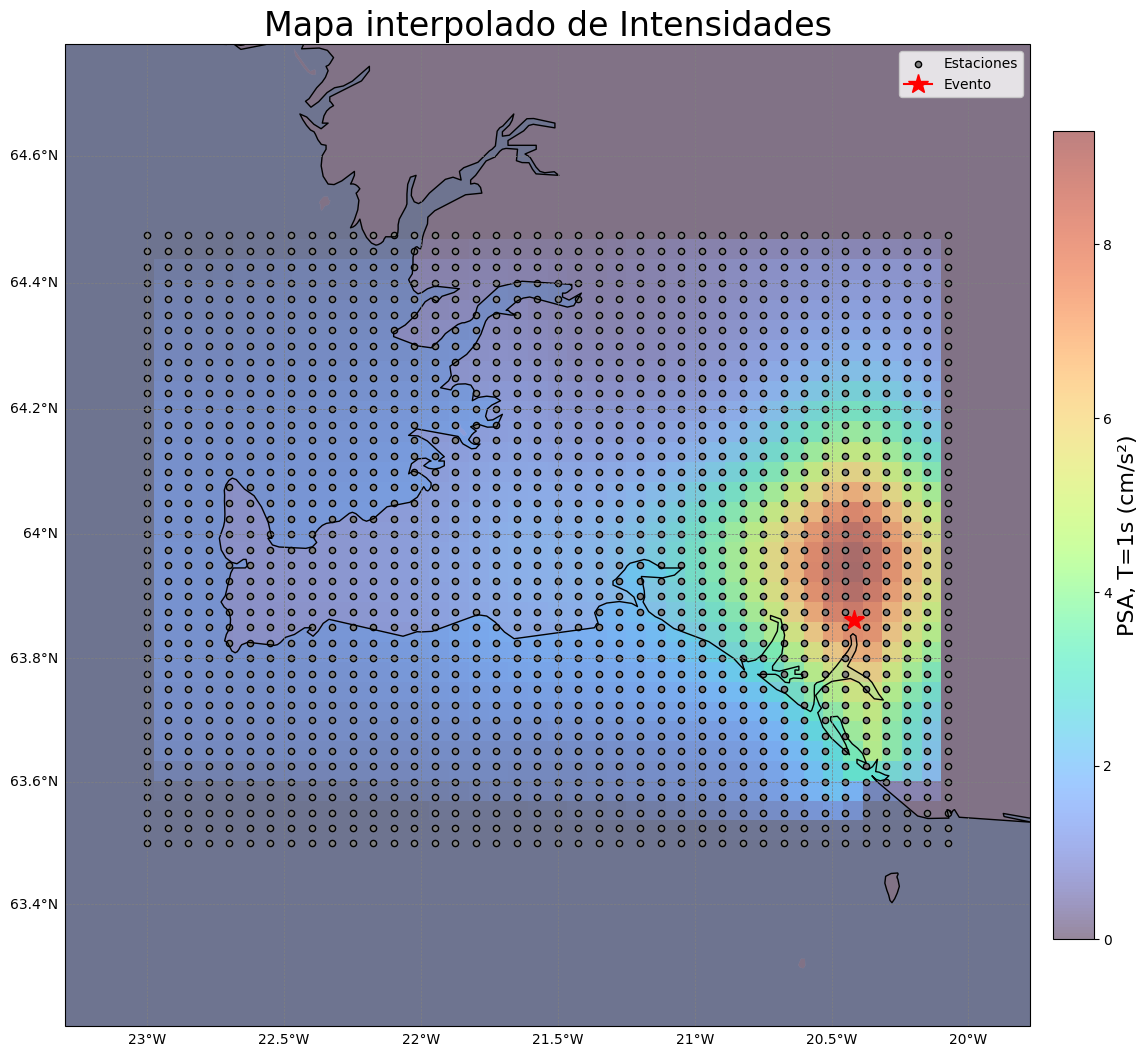

In [ ]:
vecStations['Site_Lon'] = dfStations['Site_Lon'].values
vecStations['Site_Lat'] = dfStations['Site_Lat'].values

lat_true = df_event['Site_Lat'].values
lon_true = df_event['Site_Lon'].values
z_true = np.power(10, df_event['y_pred'].values)

LonMin = vecStations['Site_Lon'].min()
LonMax = vecStations['Site_Lon'].max()
LatMin = vecStations['Site_Lat'].min()
LatMax = vecStations['Site_Lat'].max()

llcrnrlon = LonMin - 0.3
urcrnrlon = LonMax + 0.3
llcrnrlat = LatMin - 0.3
urcrnrlat = LatMax + 0.3

region = [llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]

size = 300
xi = np.linspace(llcrnrlon, urcrnrlon, size)
yi = np.linspace(llcrnrlat, urcrnrlat, size)
xgrid, ygrid = np.meshgrid(xi, yi)

points = np.column_stack((lon_true, lat_true))
grid_z = griddata(points, z_true, (xgrid, ygrid), method='linear', fill_value=0)

ds = xr.DataArray(grid_z, coords=[yi, xi], dims=["lat", "lon"])

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent(region, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.top_labels = gl.right_labels = False

im = ax.pcolormesh(xi, yi, ds.values, cmap='turbo', transform=ccrs.PlateCarree(), shading='auto', alpha=0.50)

ax.scatter(vecStations['Site_Lon'], vecStations['Site_Lat'], 
           color='gray', edgecolor='black', s=20,
           transform=ccrs.PlateCarree(), label="Estaciones")

ax.plot(longitude_event, latitude_event, marker='*', markersize=15, 
        color='red', transform=ccrs.PlateCarree(), label='Evento')


cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)
cbar.set_label(f"PSA, T={period}s (cm/s²)", fontsize=16)

plt.title("Mapa interpolado de Intensidades", fontsize=24)
plt.legend()
plt.show()
